In [1]:
import numpy as np
import matplotlib.pyplot as plt

# RNNの勾配消失・勾配爆発

シンプルなRNN（**Elman**）では、BPTTにおいて勾配消失や勾配爆発が起こることが原因で、時系列データの長期の依存関係を学習することが苦手。

以下のように、tanh関数を通過するたびに、勾配は繰り返し弱められる（**勾配消失**）。

<function matplotlib.pyplot.show(close=None, block=None)>

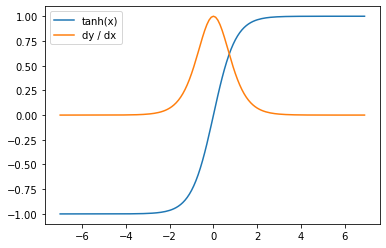

In [2]:
def tanh(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

def dy(x):
    y = tanh(x)
    return 1 - y ** 2

x = np.arange(-7.0, 7.0, 0.1)
y1 = tanh(x)
y2 = dy(x)
plt.plot(x, y1, label='tanh(x)')
plt.plot(x, y2, label='dy / dx')
plt.ylim(-1.1, 1.1)
plt.legend()
plt.show

以下のように、行列$Wh$を$T$回乗算すると、勾配は指数的に増加（**勾配爆発**）したり、指数的に減少（**勾配消失**）する。

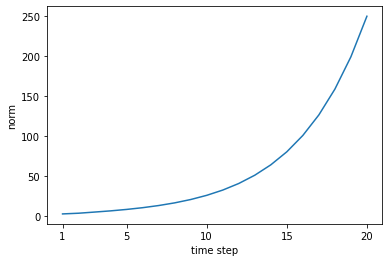

In [16]:
N = 2  # ミニバッチサイズ
H = 3  # 隠れ状態ベクトルの次元数
T = 20  # 時系列データの長さ

dh = np.ones((N, H)) # dhを初期化
np.random.seed(3)
Wh = np.random.randn(H, H)

norm_list = []
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

# グラフの描画
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

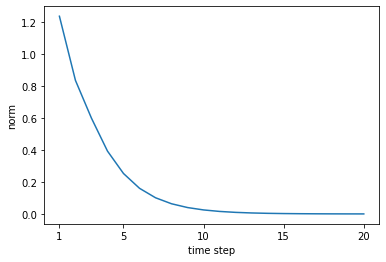

In [14]:
dh = np.ones((N, H)) # dhを初期化
np.random.seed(3)
Wh = np.random.randn(H, H) * 0.5

norm_list = []
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

# グラフの描画
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

## 勾配爆発の対策

**勾配クリッピング**と呼ばれる手法が定番。以下のように、勾配のL2ノルムがしきい値$threshold$を超えた場合、勾配を修正する。<br>

$\left\| \widehat{g}\right\| \geqq threshold$　のとき $\quad \widehat{g}=\dfrac{threshold}{\left\| \widehat{g}\right\| }\widehat{g}$

$\widehat{g}$：全てのパラメータの勾配をひとつにまとめたもの

In [17]:
dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0


def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate


print('before:', dW1.flatten())
clip_grads(grads, max_norm)
print('after:', dW1.flatten())

before: [6.49144048 2.78487283 6.76254902 5.90862817 0.23981882 5.58854088
 2.59252447 4.15101197 2.83525082]
after: [1.49503731 0.64138134 1.55747605 1.36081038 0.05523244 1.28709139
 0.59708178 0.95601551 0.65298384]


## 勾配消失の対策

**LSTM**や**GRU**などの「ゲート付きRNN」では勾配消失を起こしにくい。

# LSTM

LSTM（Long Short-Term-Memory）は，ゲート機構（gate mechanism）の追加により、短期記憶の長期伝達を可能にした改良版RNN。<br>
LSTMは、RNNの短期的な記憶$\mathrm{h}_t$に加え、短期情報を長く保持する$\mathrm{c}_t$を、記憶セルと呼ばれるブロック構造の内部メモリとして使用する。

## LSTMの構造

記憶セル$\mathrm{c}$の逆伝播について、通るのは「$+$」ノードと「$\times$」ノード（行列の積ではなく**要素ごと**の積）だけであり、勾配消失（爆発）が起きにくい。

![](LSTMimage.png)

### outputゲート

$\sigma ()$でシグモイド間数を表し、ゲートの開き具合もパラメータとして学習する（一般に、ゲートなどの割合には$\mathrm{sigmoid}()$が活性化関数として使われる）。

$$\mathbf{o}=\sigma \left( \mathrm{x}_{t}\mathrm{W}_{\mathrm{x}}^{\left( \mathbf{o}\right)}+\mathrm{h}_{t-1}\mathrm{W}_{\mathrm{h}}^{\left( \mathbf{o}\right) }+ \mathrm{b}^{\left( \mathbf{o}\right) }\right)$$

最終的に$\mathbf{o}$と$\tanh \left( \mathrm{c}_t\right)$の要素ごとの積（**アダマール積**）を計算し、出力部分とする。

$$\mathrm{h}_{t}=\mathbf{o} \odot \tanh \left( \mathrm{c}_t\right)$$

### forgetゲート

$\mathrm{c}_{t-1}$の記憶から不要な記憶を忘れ、重要な要素を届けるためのゲートを追加する。

$$\mathbf{f}=\sigma \left( \mathrm{x}_{t}\mathrm{W}_{\mathrm{x}}^{\left( \mathbf{f}\right)}+\mathrm{h}_{t-1}\mathrm{W}_{\mathrm{h}}^{\left( \mathbf{f}\right) }+ \mathrm{b}^{\left( \mathbf{f}\right) }\right)$$

$\mathbf{f}$と$\mathrm{c}_{t-1}$のアダマール積によって仮の記憶$\mathrm{c}_{t}^{(\mathbf{f})}$が求まる。

$$\mathrm{c}_{t}^{(\mathbf{f})}=\mathbf{f} \odot \mathrm{c}_{t-1}$$

### inputゲート

新しく覚える情報を記憶セルに追加する（一般に、実質的な情報に対する強弱には$\tanh()$が活性化関数として使われる）。

$$\mathbf{g}=\tanh \left( \mathrm{x}_{t}\mathrm{W}_{\mathrm{x}}^{\left( \mathbf{g}\right)}+\mathrm{h}_{t-1}\mathrm{W}_{\mathrm{h}}^{\left( \mathbf{g}\right) }+ \mathrm{b}^{\left( \mathbf{g}\right) }\right)$$

新しい記憶$\mathbf{g}$の価値を判断する。

$$\mathbf{i}=\sigma \left( \mathrm{x}_{t}\mathrm{W}_{\mathrm{x}}^{\left( \mathbf{i}\right)}+\mathrm{h}_{t-1}\mathrm{W}_{\mathrm{h}}^{\left( \mathbf{i}\right) }+ \mathrm{b}^{\left( \mathbf{i}\right) }\right)$$

先の仮の記憶$\mathrm{c}_{t}^{(\mathbf{f})}$に加算されることで新しい記憶が生まれる。

$$\mathrm{c}_{t}=\mathrm{c}_{t}^{(\mathbf{f})}+\mathbf{g} \odot \mathbf{i}$$

## 実装

### LSTMの実装

In [3]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        '''
        Wx: 入力`x`用の重みパラーメタ（4つ分の重みをまとめる）(D×4H)
        Wh: 隠れ状態`h`用の重みパラメータ（4つ分の重みをまとめる）(H×4H)
        b: バイアス（4つ分のバイアスをまとめる）
        '''
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev, c_prev): # x: (N×D); h_prev: (N×H)
        Wx, Wh, b = self.params
        N, H = h_prev.shape

        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

        # slice
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]

        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)

        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        dA = np.hstack((df, dg, di, do)) # 横方向に連結

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev

### TimeLSTMの実装

RNNの時と同様に、$T$個分の時系列データをまとめて処理する。

In [4]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None

## RNNLM

![](RNNLM_LSTM_image.png)

### LstmRnnlmクラスの実装

In [5]:
from common.time_layers import *
from common.base_model import BaseModel


class LstmRnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 重みの初期化
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # レイヤの生成
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # すべての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()

### 学習コード

Done
Done
| epoch 1 |  iter 1 / 1327 | time 0[s] | perplexity 9999.69
| epoch 1 |  iter 21 / 1327 | time 4[s] | perplexity 2965.95
| epoch 1 |  iter 41 / 1327 | time 8[s] | perplexity 1249.05
| epoch 1 |  iter 61 / 1327 | time 13[s] | perplexity 965.72
| epoch 1 |  iter 81 / 1327 | time 17[s] | perplexity 784.12
| epoch 1 |  iter 101 / 1327 | time 21[s] | perplexity 673.06
| epoch 1 |  iter 121 / 1327 | time 25[s] | perplexity 646.94
| epoch 1 |  iter 141 / 1327 | time 29[s] | perplexity 602.24
| epoch 1 |  iter 161 / 1327 | time 34[s] | perplexity 569.24
| epoch 1 |  iter 181 / 1327 | time 38[s] | perplexity 597.88
| epoch 1 |  iter 201 / 1327 | time 42[s] | perplexity 508.56
| epoch 1 |  iter 221 / 1327 | time 47[s] | perplexity 500.48
| epoch 1 |  iter 241 / 1327 | time 52[s] | perplexity 449.41
| epoch 1 |  iter 261 / 1327 | time 57[s] | perplexity 474.74
| epoch 1 |  iter 281 / 1327 | time 63[s] | perplexity 453.54
| epoch 1 |  iter 301 / 1327 | time 68[s] | perplexity 393.87
| ep

| epoch 2 |  iter 1241 / 1327 | time 749[s] | perplexity 128.84
| epoch 2 |  iter 1261 / 1327 | time 757[s] | perplexity 124.02
| epoch 2 |  iter 1281 / 1327 | time 765[s] | perplexity 122.40
| epoch 2 |  iter 1301 / 1327 | time 771[s] | perplexity 157.42
| epoch 2 |  iter 1321 / 1327 | time 778[s] | perplexity 151.20
| epoch 3 |  iter 1 / 1327 | time 781[s] | perplexity 159.45
| epoch 3 |  iter 21 / 1327 | time 789[s] | perplexity 141.30
| epoch 3 |  iter 41 / 1327 | time 795[s] | perplexity 134.93
| epoch 3 |  iter 61 / 1327 | time 801[s] | perplexity 126.47
| epoch 3 |  iter 81 / 1327 | time 808[s] | perplexity 117.04
| epoch 3 |  iter 101 / 1327 | time 814[s] | perplexity 104.34
| epoch 3 |  iter 121 / 1327 | time 821[s] | perplexity 114.56
| epoch 3 |  iter 141 / 1327 | time 828[s] | perplexity 126.00
| epoch 3 |  iter 161 / 1327 | time 835[s] | perplexity 141.34
| epoch 3 |  iter 181 / 1327 | time 841[s] | perplexity 150.44
| epoch 3 |  iter 201 / 1327 | time 848[s] | perplexity 

| epoch 4 |  iter 1141 / 1327 | time 1590[s] | perplexity 99.11
| epoch 4 |  iter 1161 / 1327 | time 1597[s] | perplexity 91.18
| epoch 4 |  iter 1181 / 1327 | time 1603[s] | perplexity 96.06
| epoch 4 |  iter 1201 / 1327 | time 1611[s] | perplexity 83.28
| epoch 4 |  iter 1221 / 1327 | time 1617[s] | perplexity 75.36
| epoch 4 |  iter 1241 / 1327 | time 1624[s] | perplexity 91.18
| epoch 4 |  iter 1261 / 1327 | time 1631[s] | perplexity 93.92
| epoch 4 |  iter 1281 / 1327 | time 1638[s] | perplexity 89.52
| epoch 4 |  iter 1301 / 1327 | time 1646[s] | perplexity 111.02
| epoch 4 |  iter 1321 / 1327 | time 1653[s] | perplexity 109.95


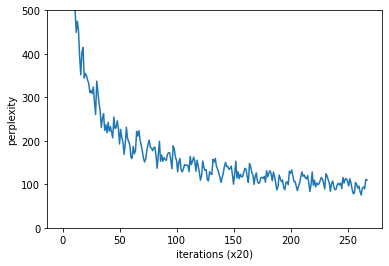

evaluating perplexity ...
234 / 235
test perplexity:  136.1159218696487


In [21]:
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb

# ハイパーパラメータの設定
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNNの隠れ状態ベクトルの要素数
time_size = 35  # RNNを展開するサイズ
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# モデルの生成
model = LstmRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 勾配クリッピングを適用して学習
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)
trainer.plot(ylim=(0, 500))

# テストデータで評価
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)

# パラメータの保存
model.save_params()

パープレキシティが135前後（10000個の中から135個程度まで絞れる）という結果。改善の余地がある。

## LstmRNNLMの改良

### LSTMレイヤの多層化

多くのニューラルネットワークのように、LSTMレイヤを多層化させることも有効（Google翻訳のGNMTではLSTMを8層重ねているとのこと）。<br>
しかしながら、RNNは通常のフィードフォワード型のネットワークよりも過学習を起こしやすいため、対策が欠かせない。<br>
- 訓練データを増やす
- L2正則化などによりモデルの複雑さを小さくする
- Dropoutを使用
 - 時系列方向にDropoutを適用すると、時間が進むにつれて情報が失われ、Dropoutによるノイズが蓄積する。<br>
 - 深さ方向にDropoutを適用すると、時間軸と独立し有効に働く。

### 重み共有

2つのレイヤで重みを共有することで、学習するパラメータを大きく減らすことができる。

### BetterLstmRnnlmクラスの実装

![](BetterRNNLM.png)
以下の点を改善し、再び学習する。
- LSTMの多層化（2層）
- Dropout適用（深さ方向）
- 重み共有（EmbeddingレイヤとAffineレイヤ）

In [6]:
from common.time_layers import *
import numpy as np
from common.base_model import BaseModel


class BetterLstmRnnlm(BaseModel):
    '''
     LSTMレイヤを2層利用し、各層にDropoutを使うモデル
     [1]で提案されたモデルをベースとし、weight tying[2][3]を利用

     [1] Recurrent Neural Network Regularization (https://arxiv.org/abs/1409.2329)
     [2] Using the Output Embedding to Improve Language Models (https://arxiv.org/abs/1608.05859)
     [3] Tying Word Vectors and Word Classifiers (https://arxiv.org/pdf/1611.01462.pdf)
    '''
    def __init__(self, vocab_size=10000, wordvec_size=650,
                 hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 3つの改善
        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)  # weight tying!!
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg

        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

### 学習コード

精度向上のため、パープレキシティが悪化した場合は学習係数を下げる工夫をする。実践的なテクニックであり、良い結果が得られる場合が多い。

In [ ]:
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb

# ハイパーパラメータの設定
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterLstmRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('valid perplexity: ', ppl)

    # パープレキシティ悪化の場合、学習係数を下げる
    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)


# テストデータでの評価
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)

| epoch 1 |  iter 1 / 1327 | time 2[s] | perplexity 9999.97
| epoch 1 |  iter 21 / 1327 | time 48[s] | perplexity 4139.59
| epoch 1 |  iter 41 / 1327 | time 89[s] | perplexity 1821.78
| epoch 1 |  iter 61 / 1327 | time 129[s] | perplexity 1234.79
| epoch 1 |  iter 81 / 1327 | time 171[s] | perplexity 1023.17
| epoch 1 |  iter 101 / 1327 | time 201[s] | perplexity 850.60
| epoch 1 |  iter 121 / 1327 | time 231[s] | perplexity 769.39
| epoch 1 |  iter 141 / 1327 | time 262[s] | perplexity 698.07
| epoch 1 |  iter 161 / 1327 | time 292[s] | perplexity 682.98
| epoch 1 |  iter 181 / 1327 | time 323[s] | perplexity 667.69
| epoch 1 |  iter 201 / 1327 | time 355[s] | perplexity 575.42
| epoch 1 |  iter 221 / 1327 | time 386[s] | perplexity 579.56
| epoch 1 |  iter 241 / 1327 | time 418[s] | perplexity 516.77
| epoch 1 |  iter 261 / 1327 | time 452[s] | perplexity 540.15
| epoch 1 |  iter 281 / 1327 | time 485[s] | perplexity 521.47
| epoch 1 |  iter 301 / 1327 | time 525[s] | perplexity 448.

パープレキシティが約75まで小さくなり、大きく精度が向上した。

## 最先端の研究

パープレキシティ52.8を達成したモデルでは、以下のような工夫により非常に高い精度を達成している。
- 多層のLSTM
- 変分Dropout
 - 時間方向にDropoutを適用する。 <br>
 - 同じ階層のDropoutでは共通のマスクを適用することで、指数的な損失を避けられ、情報の失われ方が固定される。
- DropConnect
 - 重みをランダムに無視する
- 厳密なハイパーパラメータチューニング
- いくつかの最適化や正則化に関するテクニック

# GRU

GRU（Gated Recurrent Unit）では、ゲートを使用するというコンセプトはそのままに、パラメータを削減し、計算時間を短縮する。<br>
パラメータが少なく計算量も小さいため、データセットのサイズが小さい場合や、モデル設計で繰り返しの試行が必要な場合に特に適する。

## GRUの構造

![](GRUimage.png)
記憶セルはなく、$\mathbf{r}$（resetゲート）と$\mathbf{z}$（updateゲート（forgetとinputの2つの役割））の2つのゲートがある。<br><br>
$\mathbf{r}$は過去の隠れ状態をどれだけ無視するかを決定する。<br>
$\mathbf{z}$は、過去の隠れ状態から忘れるべき情報を消去する機能と、新しく追加する情報の重みづけする機能を持つ。

$$\mathbf{z}=\sigma \left( \mathrm{x}_{t}\mathrm{W}_{\mathrm{x}}^{\left( \mathbf{z}\right)}+\mathrm{h}_{t-1}\mathrm{W}_{\mathrm{h}}^{\left( \mathbf{z}\right) }+ \mathrm{b}^{\left( \mathbf{z}\right) }\right)$$

$$\mathbf{r}=\sigma \left( \mathrm{x}_{t}\mathrm{W}_{\mathrm{x}}^{\left( \mathbf{r}\right)}+\mathrm{h}_{t-1}\mathrm{W}_{\mathrm{h}}^{\left( \mathbf{r}\right) }+ \mathrm{b}^{\left( \mathbf{r}\right) }\right)$$

$$\tilde {\mathrm{h}}=\tanh \left( \mathrm{x}_{t}\mathrm{W}_{\mathrm{x}}+\left( \mathbf{r} \odot \mathrm{h}_{t-1}\right)\mathrm{W}_{\mathrm{h}}+ \mathrm{b}\right)$$

$$\mathrm{h}_{t}=\left( 1-z\right) \odot \mathrm{h}_{t-1}+z \odot \tilde {\mathrm{h}}$$

## 実装

### GRUの実装

In [59]:
class GRU:
    def __init__(self, Wx, Wh, b):
        '''
        Wx: 入力`x`用の重みパラーメタ（3つ分の重みをまとめる）
        Wh: 隠れ状態`h`用の重みパラメータ（3つ分の重みをまとめる）
        b: バイアス（3つ分のバイアスをまとめる）
        '''
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        H = Wh.shape[0]
        Wxz, Wxr, Wxh = Wx[:, :H], Wx[:, H:2 * H], Wx[:, 2 * H:]
        Whz, Whr, Whh = Wh[:, :H], Wh[:, H:2 * H], Wh[:, 2 * H:]
        bz, br, bh = b[:H], b[H:2 * H], b[2 * H:]

        z = sigmoid(np.dot(x, Wxz) + np.dot(h_prev, Whz) + bz)
        r = sigmoid(np.dot(x, Wxr) + np.dot(h_prev, Whr) + br)
        h_hat = np.tanh(np.dot(x, Wxh) + np.dot(r*h_prev, Whh) + bh)
        h_next = (1-z) * h_prev + z * h_hat

        self.cache = (x, h_prev, z, r, h_hat)

        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        H = Wh.shape[0]
        Wxz, Wxr, Wxh = Wx[:, :H], Wx[:, H:2 * H], Wx[:, 2 * H:]
        Whz, Whr, Whh = Wh[:, :H], Wh[:, H:2 * H], Wh[:, 2 * H:]
        x, h_prev, z, r, h_hat = self.cache

        dh_hat =dh_next * z
        dh_prev = dh_next * (1-z)

        # tanh
        dt = dh_hat * (1 - h_hat ** 2)
        dbh = np.sum(dt, axis=0)
        dWhh = np.dot((r * h_prev).T, dt)
        dhr = np.dot(dt, Whh.T)
        dWxh = np.dot(x.T, dt)
        dx = np.dot(dt, Wxh.T)
        dh_prev += r * dhr

        # update gate(z)
        dz = dh_next * h_hat - dh_next * h_prev
        dt = dz * z * (1-z)
        dbz = np.sum(dt, axis=0)
        dWhz = np.dot(h_prev.T, dt)
        dh_prev += np.dot(dt, Whz.T)
        dWxz = np.dot(x.T, dt)
        dx += np.dot(dt, Wxz.T)

        # rest gate(r)
        dr = dhr * h_prev
        dt = dr * r * (1-r)
        dbr = np.sum(dt, axis=0)
        dWhr = np.dot(h_prev.T, dt)
        dh_prev += np.dot(dt, Whr.T)
        dWxr = np.dot(x.T, dt)
        dx += np.dot(dt, Wxr.T)

        self.dWx = np.hstack((dWxz, dWxr, dWxh))
        self.dWh = np.hstack((dWhz, dWhr, dWhh))
        self.db = np.hstack((dbz, dbr, dbh))

        self.grads[0][...] = self.dWx
        self.grads[1][...] = self.dWh
        self.grads[2][...] = self.db

        return dx, dh_prev

### TimeGruの実装

In [60]:
class TimeGRU:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        self.h, self.dh = None, None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = GRU(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)
        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')

        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad

        self.dh = dh
        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None